In [1]:
import torch
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

path = "/Users/ismagil//Downloads/Concrete Crack Images for Classification"
data = []            # Список для изображений
data_labels = []     # Список для меток
data_path = []       # Список для путей к изображениям
batch_size = 20
num_epochs = 10

In [2]:
# Список классов (без трещин, с трещинами)
classes = ["Negative", "Positive"]

new_width = 48
new_height = 48

for label, view in enumerate(classes):
    class_path_train = os.path.join(path, view)
    files_train = os.listdir(class_path_train)

    data.extend([cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(class_path_train, file)), cv2.COLOR_BGR2GRAY), (new_width, new_height)) for file in files_train])
    data_labels.extend([label] * len(files_train))
    data_path.extend([os.path.join(class_path_train, file) for file in files_train])

In [3]:
# Нормализация значений пикселей изображений до диапазона [0, 1]
data = np.array(data) / 255.0

In [4]:
# Отображение данных из датасета
print(f"Количество снимков: {len(data)}")

fig = plt.figure(figsize=(16, 4))
for i, data_point in enumerate(data[:3]):
    print(data_labels[i], data[i].shape)
    fig.add_subplot(1,3,i+1)
    plt.imshow(data_point, cmap='gray')
    plt.axis('off')
plt.show()

SIZE_Y, SIZE_X = data[0].shape
print(f"Размеры снимков W: {SIZE_X}, H: {SIZE_Y}")

Количество снимков: 40000
0 (48, 48)
0 (48, 48)
0 (48, 48)


Размеры снимков W: 48, H: 48


In [16]:
# Разделение данных
def data_split(d, lbls, pth, tr=0.7, ts=0.2, val=0.1):
    total = len(d)
    train_size = int(total * tr)
    test_size = int(total * ts)
    validation_size = total - train_size - test_size

    train_data = d[:train_size]
    train_labels = lbls[:train_size]
    train_paths = pth[:train_size]

    test_data = d[train_size:train_size + test_size]
    test_labels = lbls[train_size:train_size + test_size]
    test_paths = pth[train_size:train_size + test_size]

    validation_data = d[-validation_size:]
    validation_labels = lbls[-validation_size:]
    validation_paths = pth[-validation_size:]

    return (train_data, train_labels, train_paths), (test_data, test_labels, test_paths), (validation_data, validation_labels, validation_paths)

train_data, test_data, validation_data = data_split(data, data_labels, data_path)
print(f"Количество снимков в тренировочном наборе: {len(train_data[0])}")
print(f"Количество снимков в тестовом наборе: {len(test_data[0])}")
print(f"Количество снимков в валидационном наборе: {len(validation_data[0])}")

Количество снимков в тренировочном наборе: 28000
Количество снимков в тестовом наборе: 8000
Количество снимков в валидационном наборе: 4000


In [6]:
# Модель сверточной нейронно сети из двух сверточных слоев
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Первый полносвязный слой: вход 32 * SIZE_Y//4 * SIZE_X//4
        # SIZE_Y или SIZE_X делим на размер размер ядра пуллинга ** кол-во пулингов
        self.fc1 = nn.Linear(32 * (SIZE_Y//4) * (SIZE_X//4), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
model = CNN()                                       # Создание модели CNN
criterion = nn.CrossEntropyLoss()                   # Функция потерь
optimizer = torch.optim.Adam(model.parameters(),    # Оптимизатор
                            lr=0.0001)              

In [8]:
# преобразование в тензоры PyTorch
train_data_tensor = torch.Tensor(train_data[0]).unsqueeze(1)
train_labels_tensor = torch.Tensor(train_data[1])

# объединение входных данных и меток
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
# Создание DataLoader для тестового набора данных
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# преобразование в тензоры PyTorch
test_data_tensor = torch.Tensor(test_data[0]).unsqueeze(1)
test_labels_tensor = torch.Tensor(test_data[1])

# объединение входных данных и меток
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)
# Создание DataLoader для тестового набора данных
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
train_loss, train_acc, test_loss, test_acc = [], [], [], []

for epoch in range(num_epochs):

    model.train() # Перевод модели в режим обучения
    correct_preds, current_loss = 0, 0.0

    # Цикл обучения по тренировочным данным
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)  # Проход данных через модель

        # Рассчет потерь и обратное распространение
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        current_loss += float(loss)

        _, predicted = torch.max(outputs, 1)
        correct_preds += sum([1 for p, l in zip(predicted, labels) if p == l])

    # Рассчет точности на тренировочных данных
    accuracy = correct_preds / len(train_data[1])

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {current_loss / len(train_loader)}, Accuracy: {accuracy * 100:.2f}%')

    train_loss.append(current_loss / len(train_loader))
    train_acc.append(accuracy)

    model.eval() # Перевод модели в режим оценки
    test_loss_val, correct_test_preds = 0.0, 0

    # Оценка модели на тестовых данных без расчета градиентов
    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_outputs = model(test_inputs)
            test_loss_val += float(criterion(test_outputs, test_labels))

            _, predicted_test = torch.max(test_outputs, 1)
            correct_test_preds += sum([1 for p, l in zip(predicted_test, test_labels) if p == l])

    # Рассчет точности на тестовых данных
    test_accuracy = correct_test_preds / len(test_data[1])

    test_loss.append(test_loss_val / len(test_loader))
    test_acc.append(test_accuracy)

Epoch 1/10, Loss: 0.17433295499533416, Accuracy: 92.79%
Epoch 2/10, Loss: 0.05889854431618005, Accuracy: 98.15%
Epoch 3/10, Loss: 0.045555710442380846, Accuracy: 98.59%
Epoch 4/10, Loss: 0.037955336173555614, Accuracy: 98.80%
Epoch 5/10, Loss: 0.03164845396843573, Accuracy: 98.98%
Epoch 6/10, Loss: 0.026181525583857106, Accuracy: 99.22%
Epoch 7/10, Loss: 0.02197219708692241, Accuracy: 99.35%
Epoch 8/10, Loss: 0.018813913173934063, Accuracy: 99.46%
Epoch 9/10, Loss: 0.017093957174001844, Accuracy: 99.45%
Epoch 10/10, Loss: 0.015480203270297872, Accuracy: 99.53%


In [18]:
plt.figure(figsize=(20, 6))

# вывод графиков точности и потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss, label='Потери на тренировочной выборке')
plt.plot(range(1, num_epochs + 1), test_loss, label='Потери на тестовой выборке')
plt.xlabel('Эпох')
plt.ylabel('Потери')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc, label='Точность на тренировочной выборке')
plt.plot(range(1, num_epochs + 1), test_acc, label='Точность на тестовой выборке')
plt.xlabel('Эпох')
plt.ylabel('Точность')
plt.legend()

plt.show()

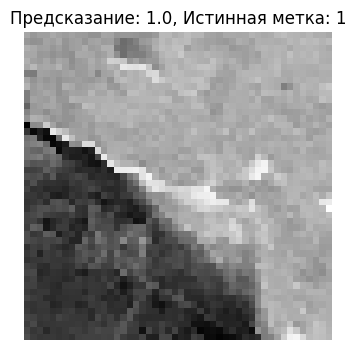

In [22]:
# Выбор случайного изображения из тестового набора
i = np.random.randint(len(test_data[0]))

# Получение данных (изображения, метки, пути) для выбранного индекса
im, lb, p = test_data[0][i], test_data[1][i], test_data[2][i]

# Преобразование изображения в тензор PyTorch
im_tensor = torch.Tensor(im).unsqueeze(0).unsqueeze(1)

# Перевод модели в режим оценки
model.eval()

# Оценка модели на выбранном изображении без вычисления градиентов
with torch.no_grad():
    o = model(im_tensor)
    _, pred_class = torch.max(o, 1)

# Преобразование предсказанного класса в число
pred_class = float(pred_class)

# Визуализация выбранного изображения с меткой и предсказанием
plt.figure(figsize=(4, 4))
plt.imshow(im, cmap='gray')
plt.title(f"Предсказание: {pred_class}, Истинная метка: {lb}")
plt.axis('off')
plt.show()